In [1]:
import numpy as np
from matplotlib import pyplot as plt
import nibabel as nb
from scipy.ndimage import gaussian_filter
from scipy.ndimage import distance_transform_edt
import sys
sys.path.append('../')
from slice_structure_identification_functions import compute_signed_distance_weight as compute_signed_distance_weight
# from slice_registration_functions import compute_signed_distance_weight

In [2]:
from skimage.measure import label, regionprops

def largest_component(binary_mask):
    labeled = label(binary_mask)
    regions = regionprops(labeled)

    if not regions:
        return np.zeros_like(binary_mask, dtype=bool)

    largest_region = max(regions, key=lambda r: r.area)
    return labeled == largest_region.label


13.0
12.862766277849737


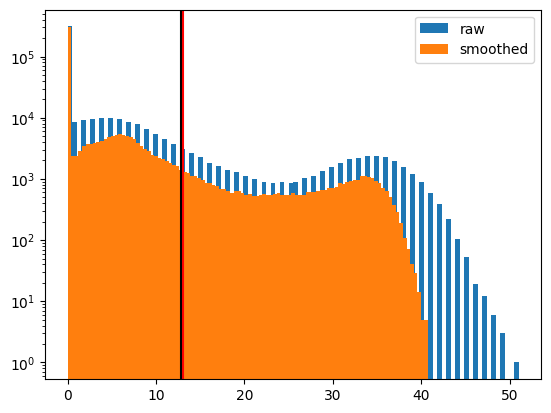

In [3]:
fname = '~/Downloads/Macaque_CB/zefir_0047__Image_34_-_20x_cellCount_29_downsample_10p002um_pix.nii.gz'
img = nb.load(fname)
data = img.get_fdata()  
_ = plt.hist(data.flatten(), bins=100,label='raw')
plt.yscale('log')
pctl = np.percentile(data, 90)
plt.axvline(pctl, color='r')

data_s = gaussian_filter(data, sigma=1)
_ = plt.hist(data_s.flatten(), bins=100, label='smoothed')
plt.yscale('log')
pctl_s = np.percentile(data_s, 90)
plt.axvline(pctl_s, color='k')
plt.legend()
print(pctl)
print(pctl_s)

img_s = nb.Nifti1Image(data_s, img.affine, img.header)
img_s.to_filename(fname.replace('.nii.gz', '_smoothed.nii.gz'))



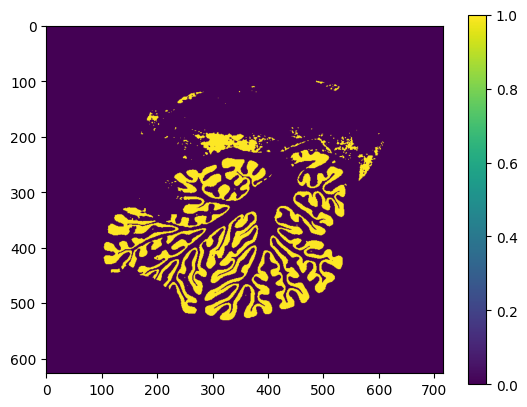

In [4]:
data_s_m = data_s>pctl_s
# data_s_m_dt = distance_transform_edt(data_s_m)# - distance_transform_edt(~data_s_m)
# data_s_m_dt[data_s_m_dt<-1*data_s_m_dt.max()] = 0 
plt.imshow(data_s_m)
plt.colorbar()
# img_s.to_filename(fname.replace('.nii.gz', '_smoothed.nii.gz'))


In [5]:
import numpy as np
from scipy.ndimage import binary_closing, binary_fill_holes
from skimage.morphology import disk  # or ball for 3D

def make_filled_mask(cortex_mask, closing_radius=5):
    """
    cortex_mask: binary array where cortex voxels = 1
    """
    # close small breaks
    closed = binary_closing(cortex_mask, structure=disk(closing_radius))
    
    # fill interior
    filled = binary_fill_holes(closed)
    
    return filled

from scipy.ndimage import distance_transform_edt

def signed_distance(mask):
    """
    mask: filled binary mask (+ve inside object, -ve outside)
    """
    # distance inside object
    dist_inside = distance_transform_edt(mask)
    
    # distance outside object
    dist_outside = distance_transform_edt(~mask)
    
    # signed distance
    sdf = dist_inside - dist_outside
    
    return sdf


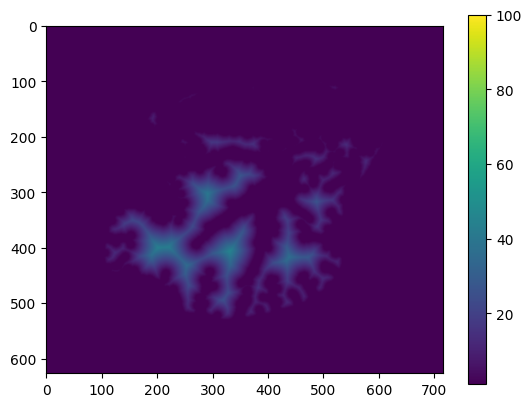

In [6]:
data_s_m = data_s>pctl_s
data_s_m_dt = signed_distance(make_filled_mask(data_s_m,closing_radius =5))# - distance_transform_edt(~data_s_m)
# data_s_m_dt[data_s_m_dt<-1*data_s_m_dt.max()] = 0 
plt.imshow(data_s_m_dt,vmin=1,vmax=100)
plt.colorbar()
# img_s.to_filename(fname.replace('.nii.gz', '_smoothed.nii.gz'))


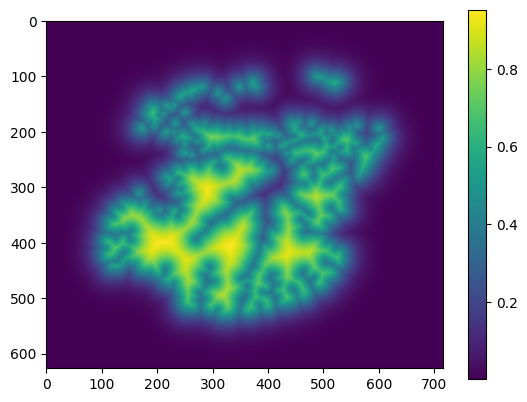

In [37]:

plt.imshow(compute_signed_distance_weight(data_s, img_smth_gauss=0,pctl_cut=90, closing_radius=5, smooth_weights_sigma=15))
plt.colorbar()

In [ ]:
data_s_m_dt.sum()

np.int64(0)